# Medium_range National Water Model Forecast
### Workflow for creating a 10-day (no ensemble members) or 8.5-day (with ensemble members) streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [8]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd

# import dask 
# from dask.distributed import Client, LocalCluster
# import dask.bag as db
# from multiprocessing import cpu_count

%matplotlib inline

## Start the local cluster
*__NOTE__*: using the local cluster and scheduler *currently* slower in computation time because of the overhead of the dask scheduler. 

Without the local cluster, xarray operates in parallel with dask if you use `xr.open_mfdataset` (otherwise xarray operates serially).

In [2]:
# num_workers = cpu_count()
# cluster = LocalCluster(n_workers=num_workers)
# client = Client(cluster)
# client

## Set up the Google Cloud File System

In [3]:
fs = gcsfs.GCSFileSystem(project='national-water-model')
# alldays = fs.ls('national-water-model')
# len(alldays)

# Set the parameters

In [4]:
date = '20190730' # a date
start_time = '00' # start at 00:00 because its easy at the moment
comid = 4512772 # some small segment on the Potomac near DC

## Open all netcdf files of interest, concat them into an xarray multifile dataset -- **_1 for each member_**

- This step takes longer than expected due to reading from GCS over the internet

#### Prior to June 2019, there was only one medium range forecast, not 7 members. The if/else accounts for that but can most likely be removed in the future

In [20]:
datepath = f'national-water-model/nwm.{date}'
if 'medium_range_mem' in str(fs.ls(datepath)): 
    xr_datasets = []
    multi_mem = True
    len_forecast = '8.5-day'
    for i in range(1,8):
        mem = str(i)
        open_ncdfs = []
        for i in range(3, 205, 3): # for times 3-240 or 3-204 in steps of 3
            hr = str(i).zfill(3)
            filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
            file = fs.open(filepath, 'rb')
            open_ncdfs.append(file)
        mfdset = xr.open_mfdataset(open_ncdfs)
        xr_datasets.append(mfdset)

else:
    multi_mem = False
    len_forecast = '10-day'
    open_ncdfs = []
    for i in range(3, 241, 3): # for times 3-240 or 3-204 in steps of 3
        hr = str(i).zfill(3)
        filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt.f{hr}.conus.nc'
        file = fs.open(filepath, 'rb')
        open_ncdfs.append(file)
    mfdset = xr.open_mfdataset(open_ncdfs)
    
print(f'Multi-member: {multi_mem}')

Multi-member: True


## Pull the data from each multifile xarray dataset, make a list of dictionaries

In [21]:
outjson = []
for ds in xr_datasets:
    output_da = ds.sel(feature_id=comid)['streamflow']
    times = output_da['time'].values.astype(str)
    arr = output_da.values
    d = {}
    d[ds.attrs['ensemble_member_number']] = dict(zip(times, arr))
    outjson.append(d)

## Dump them into a pandas dataframe

In [27]:
df = pd.concat([pd.read_json(json.dumps(x), orient='index') for x in outjson]).T
df['mean'] = df.mean(axis=1)
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996
2019-07-30 06:00:00,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996
2019-07-30 09:00:00,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996
2019-07-30 12:00:00,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996
2019-07-30 15:00:00,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996


## Stats

In [28]:
stats = df.T.describe()
stats

,2019-07-30 03:00:00,2019-07-30 06:00:00,2019-07-30 09:00:00,2019-07-30 12:00:00,2019-07-30 15:00:00,2019-07-30 18:00:00,2019-07-30 21:00:00,2019-07-31 00:00:00,2019-07-31 03:00:00,2019-07-31 06:00:00,...,2019-08-06 09:00:00,2019-08-06 12:00:00,2019-08-06 15:00:00,2019-08-06 18:00:00,2019-08-06 21:00:00,2019-08-07 00:00:00,2019-08-07 03:00:00,2019-08-07 06:00:00,2019-08-07 09:00:00,2019-08-07 12:00:00
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,150.172854,150.709997,151.459997,152.202854,152.487139,152.619997,152.655711,153.057139,152.285711,151.491425
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.963063,11.404405,14.355203,17.120796,18.708139,20.306020,21.640159,22.808128,23.084296,22.625232
min,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,142.399997,141.189997,140.039997,138.939997,137.909997,136.949997,136.059997,135.239997,134.469997,133.769997
25%,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,143.442497,142.267497,141.119997,140.047497,139.214997,138.227497,137.332497,136.614997,136.094997,135.784997
50%,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,148.866425,148.889997,149.039997,149.176425,149.038568,148.779997,148.442854,148.288568,147.602854,146.975711
75%,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,152.384997,152.969997,153.617497,154.409997,155.164997,155.577497,155.834997,156.729996,155.847497,154.184997
max,171.659996,184.919996,186.599996,184.489996,181.629996,178.769996,175.989996,173.279996,170.689996,168.249996,...,169.739996,175.939996,183.809996,191.099996,194.889996,198.769996,201.909995,204.359995,204.899995,203.129995


## Plot the stream flow and the statistics

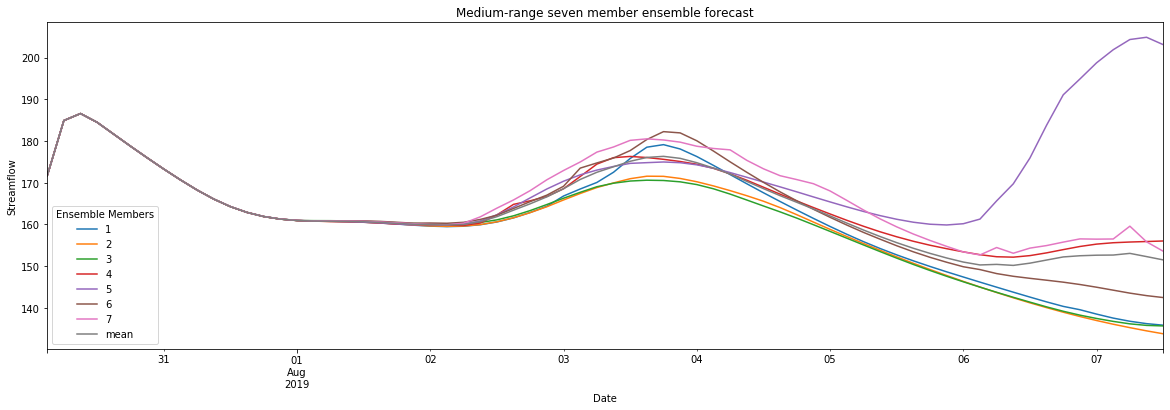

In [44]:
ax = df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.set(xlabel='Date', ylabel='Streamflow');

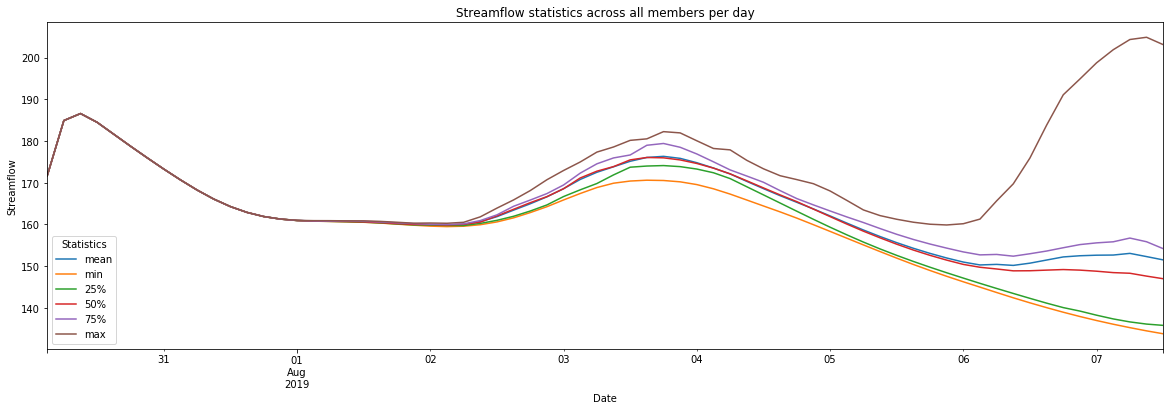

In [45]:
ax = stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.set(xlabel='Date', ylabel='Streamflow');

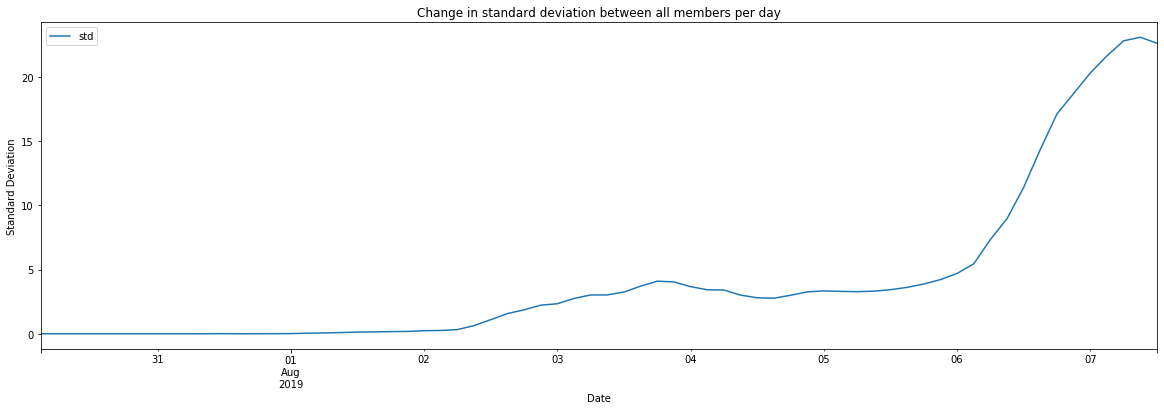

In [39]:
ax = stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.set(xlabel='Date', ylabel='Standard Deviation');